In [1]:
import transformers
from os import path as osp
import sys
from config import parse_args
from data_helper import BaseModelDataset
from torch.utils.data import SequentialSampler, DataLoader
from model import Model_v1 as Model
import torch
import os
import numpy as np
from utils import eval_fcn
from tqdm import tqdm

/home/yfzx/anaconda3/envs/yangsc_torch15/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = parse_args()
sys.path.append(args.root)

In [3]:
import json
from logger import get_logger
logging = get_logger(filename='tmp.log')

anns=list()
with open(args.train_filepath,'r',encoding='utf8') as f:
    for line in f.readlines():
        ann =json.loads(line)
        anns.append(ann)

In [4]:
dataset = BaseModelDataset(args, anns, test_mode=False)
sampler = SequentialSampler(dataset)
dataloader = DataLoader(dataset,
                        batch_size=args.test_batch_size,
                        sampler=sampler,
                        drop_last=False,
                        pin_memory=True,
                        num_workers=args.num_workers,
                        prefetch_factor=args.prefetch)

In [6]:
# 2. load model
model = Model(args)
if torch.cuda.is_available():
    model = model.cuda()

cv = 0
# get the filename of the max f1 score from this cv
thiscv = [x for x in os.listdir(args.savedmodel_filepath) if f'cv{cv}' in x]
f1s = np.array([eval('0.'+x.split('_')[-1].split('.')[1]) for x in thiscv])
selected = thiscv[np.where(f1s==max(f1s))[0][0]]
args.ckpt_file = osp.join(args.savedmodel_filepath, selected)

checkpoint = torch.load(args.ckpt_file)
model.load_state_dict(checkpoint['model_state_dict'],strict=False)

Some weights of the model checkpoint at /home/yfzx/work/yangsc/ccf2022_cls/data/model/pytorch/chinese-roberta-wwm-ext were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /home/yfzx/work/yangsc/ccf2022_cls/data/model/p

<All keys matched successfully>

### here we test f1 score for whole trainset before split

In [7]:
# 3. inference
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in tqdm(dataloader):
        batch = {k:v.to('cuda') for k,v in batch.items()}
        pred_label_id, out = model(data=batch)
        predictions.extend(pred_label_id.cpu().numpy())
        true_labels.extend(batch['label'].cpu().numpy())

results = eval_fcn(predictions, true_labels)
print(len(true_labels))
results

100%|██████████| 4/4 [00:10<00:00,  2.71s/it]

958


{'f1_macro': 0.9532639912947807,
 'f1_micro': 0.9613778705636743,
 'f1_weight': 0.9612706800788096}

### test f1 score difference between train and test sets

In [98]:
from data_helper import Dataloaders
from sklearn.metrics import f1_score
epoch = 0
args.batch_size = args.test_batch_size

def get_res(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = {k:v.to('cuda') for k,v in batch.items()}
            pred_label_id, out = model(data=batch)
            predictions.extend(pred_label_id.cpu().numpy())
            true_labels.extend(batch['label'].cpu().numpy())

    return eval_fcn(predictions, true_labels), f1_score(true_labels, predictions, average=None)

total_f1s = []
for cv in range(6):
    print(f'result at cv{cv}')
    # get the filename of the max f1 score from this cv
    thiscv = [x for x in os.listdir(args.savedmodel_filepath) if f'cv{cv}' in x]
    f1s = np.array([eval('0.'+x.split('_')[-1].split('.')[1]) for x in thiscv])
    selected = thiscv[np.where(f1s==max(f1s))[0][0]]
    args.ckpt_file = osp.join(args.savedmodel_filepath, selected)

    checkpoint = torch.load(args.ckpt_file)
    model.load_state_dict(checkpoint['model_state_dict'],strict=False)

    args.cv_id = cv
    dataloaders = Dataloaders(args,total_epochs=args.max_epochs)
    train_dataloader, val_dataloader, aug_dataloader, pseudo_dataloader = dataloaders.get(epoch)
    
    res, _ = get_res(model, train_dataloader)
    print(f"trainset score: {res}")

    res, f1 = get_res(model, val_dataloader)
    print(f"valset score: {res}")

    print(f1)
    print(f1.mean())
    total_f1s.append(f1)

result at cv0


100%|██████████| 6/6 [00:16<00:00,  2.70s/it]


trainset score: {'f1_macro': 1.0, 'f1_micro': 1.0, 'f1_weight': 1.0}


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


valset score: {'f1_macro': 0.6895344239094239, 'f1_micro': 0.76875, 'f1_weight': 0.7484969457625709}
[0.92307692 0.8        0.8125     0.8        0.6        0.85714286
 0.625      0.875      0.75       1.         0.66666667 0.66666667
 0.         0.66666667 0.         0.90909091 1.         0.4
 0.85714286 1.         0.85714286 0.66666667 0.66666667 0.85714286
 1.         1.         1.         0.4        0.         0.66666667
 0.66666667 0.66666667 0.         1.         0.5        0.66666667]
0.6895344239094239
result at cv1


100%|██████████| 6/6 [00:16<00:00,  2.71s/it]


trainset score: {'f1_macro': 0.9977485362356977, 'f1_micro': 0.9967447916666666, 'f1_weight': 0.9967274480647613}


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


valset score: {'f1_macro': 0.6484273161771581, 'f1_micro': 0.71875, 'f1_weight': 0.6994536021510641}
[0.66666667 0.75       0.74193548 0.72727273 0.25       0.90909091
 0.66666667 0.88888889 0.76923077 0.72727273 0.66666667 0.70588235
 0.         0.         0.8        0.85714286 1.         1.
 0.66666667 0.66666667 0.85714286 0.66666667 0.         0.75
 0.8        0.66666667 0.66666667 0.57142857 0.66666667 1.
 0.66666667 1.         0.         1.         0.57142857 0.        ]
0.6484273161771581
result at cv2


100%|██████████| 6/6 [00:16<00:00,  2.72s/it]


trainset score: {'f1_macro': 1.0, 'f1_micro': 1.0, 'f1_weight': 1.0}


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


valset score: {'f1_macro': 0.6666374409001138, 'f1_micro': 0.75625, 'f1_weight': 0.7392630219243123}
[1.         0.85714286 0.77419355 0.85714286 0.66666667 0.57142857
 0.53333333 0.875      0.54545455 0.90909091 0.76190476 0.75
 0.         0.75       0.85714286 0.8        1.         0.8
 0.66666667 1.         0.85714286 0.5        0.         0.8
 0.8        0.66666667 0.66666667 0.8        0.         1.
 0.8        0.         0.8        0.66666667 0.        ]
0.6666374409001138
result at cv3


100%|██████████| 6/6 [00:16<00:00,  2.73s/it]


trainset score: {'f1_macro': 0.9987944066515495, 'f1_micro': 0.9986979166666666, 'f1_weight': 0.9986740894274376}


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


valset score: {'f1_macro': 0.6820797540591987, 'f1_micro': 0.7, 'f1_weight': 0.6989343840583071}
[0.8        0.85714286 0.63492063 0.72727273 0.5        0.92307692
 0.58823529 0.93333333 0.71428571 0.66666667 0.69565217 0.52631579
 0.         0.33333333 0.66666667 0.83333333 1.         0.4
 0.66666667 0.8        0.8        1.         0.66666667 0.8
 1.         0.66666667 0.85714286 0.         0.66666667 0.66666667
 1.         0.8        1.         0.        ]
0.6820797540591987
result at cv4


100%|██████████| 6/6 [00:16<00:00,  2.74s/it]


trainset score: {'f1_macro': 1.0, 'f1_micro': 1.0, 'f1_weight': 1.0}


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


valset score: {'f1_macro': 0.7148029893861203, 'f1_micro': 0.7672955974842768, 'f1_weight': 0.7576765079321915}
[0.28571429 0.66666667 0.78688525 0.75       0.52631579 0.8
 0.75       0.82352941 0.92307692 0.8        0.85714286 0.88888889
 0.         0.5        0.33333333 0.90909091 1.         0.66666667
 0.5        1.         1.         0.8        1.         1.
 0.88888889 0.66666667 0.8        0.57142857 0.         1.
 0.85714286 0.         1.         0.66666667 1.        ]
0.7148029893861203
result at cv5


100%|██████████| 6/6 [00:16<00:00,  2.75s/it]


trainset score: {'f1_macro': 0.9992843201040988, 'f1_micro': 0.9993489583333334, 'f1_weight': 0.999345061402082}


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]

valset score: {'f1_macro': 0.6951847613934817, 'f1_micro': 0.7232704402515723, 'f1_weight': 0.7156688512725665}
[0.58823529 0.8        0.77192982 0.44444444 0.75       0.57142857
 0.71428571 0.875      0.8        0.4        0.63636364 0.8
 1.         0.8        1.         0.66666667 1.         0.
 0.8        1.         0.57142857 0.66666667 0.         0.75
 0.90909091 0.8        0.8        0.44444444 1.         1.
 0.         1.         0.         0.66666667 1.         1.        ]
0.6951847613934817


### there is hugh score difference between trainset and valset, lets see if this is cause by sample imbalance

In [11]:
labels = [x['label_id'] for x in anns]
print(len(labels))
_, counts = np.unique(labels, return_counts=True)

958


In [13]:
print(sum(counts[:18]))
print(sum(counts[18:]))

718
240


### the sample size between first and second half is more than 3x difference

In [111]:
# put predictions of each class from every fold together & check variance
tot = []
for i in range(36):
    # if i > 0:
    #     break
    tmp = []
    for j in range(6):
        try:
            tmp.append(total_f1s[j][i])
        except:
            pass
    tot.append(tmp)

vars = []
for clss in tot:
    vars.append(np.var(clss))
    print(np.var(clss))

0.05572038177016819
0.004335632401108592
0.003259658243318616
0.017018793751898607
0.024860640880954823
0.021684875231328764
0.005396200555385553
0.0010288547911297167
0.012656516324723114
0.03671156004489338
0.005604942349514729
0.012721375050273915
0.13888888888888892
0.07627314814814815
0.11685563114134544
0.006805454045713792
0.0
0.104320987654321
0.012953514739229026
0.01728395061728395
0.016439909297052146
0.023611111111111114
0.16358024691358022
0.0073582766439909296
0.006700903535920361
0.015432098765432107
0.013134290753338378
0.05929173315416702
0.16358024691358022
0.02469135802469136
0.10159989921894684
0.18024691358024691
0.22222222222222224
0.11111111111111112
0.1379591836734694
0.1728395061728395


In [112]:
print(sum(vars[:18]))
print(sum(vars[18:]))

0.6441435412731152
1.4500364764482132


### variance for little sample class is much higher, so lets improve by:
1. make loss weights weighted by sample size
2. new samplling strategy for over/under sampling
3. pseudo_label weighted thresholds

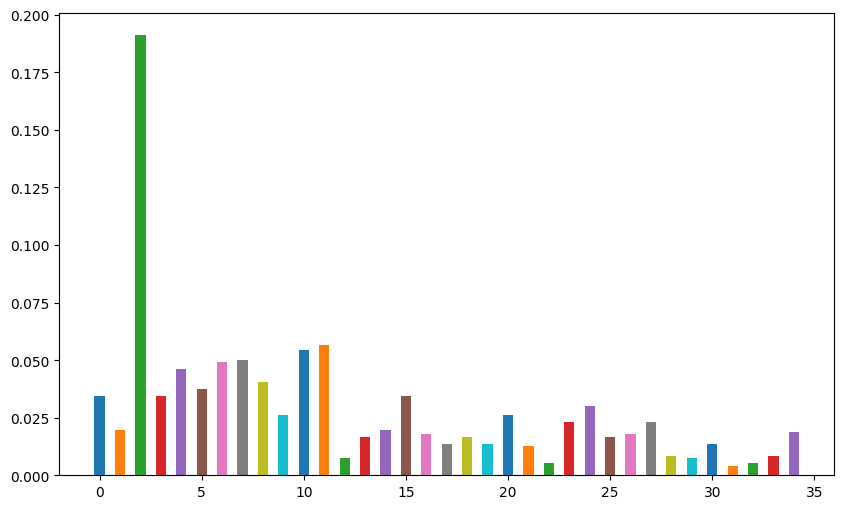

In [30]:
freq = [x/sum(counts) for x in counts]
import matplotlib.pyplot as plt
xs=[*range(len(freq))]
ys=freq

plt.figure(figsize=(10,6), dpi=100)
for x, y in zip(xs, ys):
    plt.bar(x, height=y, width=0.5)
plt.show()

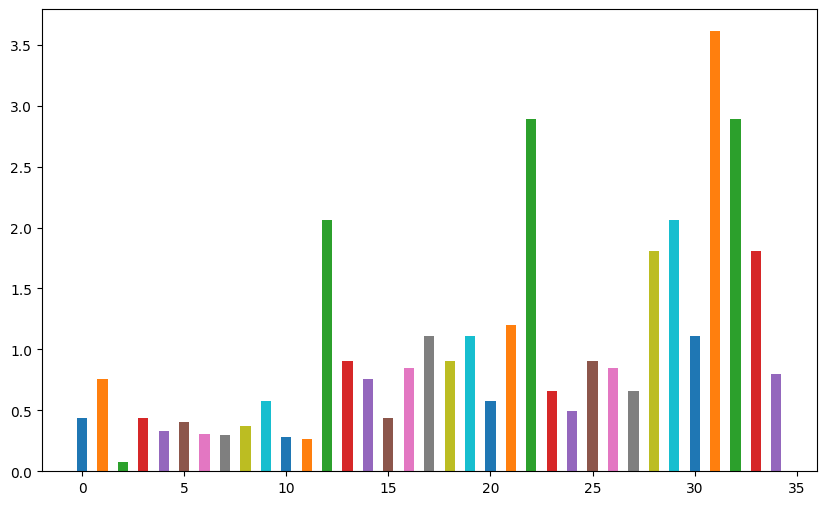

In [51]:
inv_count = [1/x for x in counts]
freq = [x/sum(inv_count)*len(counts) for x in inv_count]

xs=[*range(len(freq))]
ys=freq

plt.figure(figsize=(10,6), dpi=100)
for x, y in zip(xs, ys):
    plt.bar(x, height=y, width=0.5)
plt.show()

In [ ]:
import torch.nn.functional as F
freq = [x/max(counts)/100 for x in counts]
xs=[*range(len(freq))]
ys=F.softmax(torch.tensor(freq).double())

plt.figure(figsize=(10,6), dpi=100)
for x, y in zip(xs, ys):
    plt.bar(x, height=y, width=0.5)
plt.show()

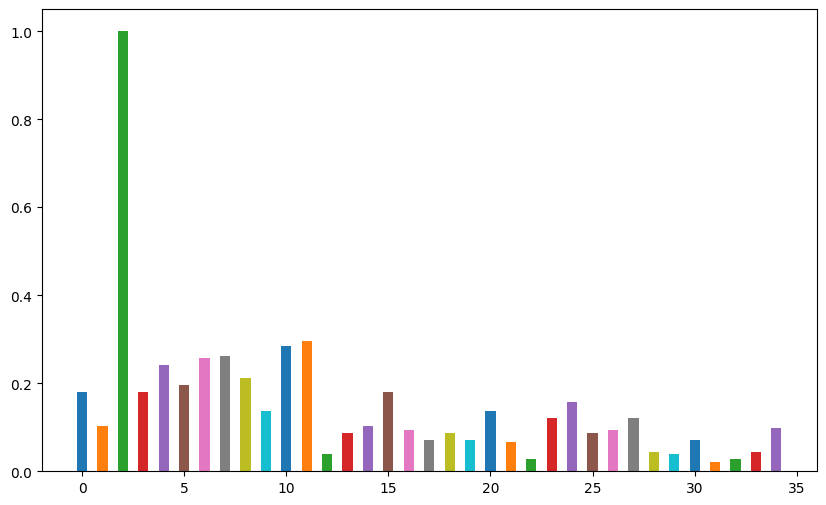

In [36]:
freq = [x/max(counts) for x in counts]
xs=[*range(len(freq))]
ys=freq

plt.figure(figsize=(10,6), dpi=100)
for x, y in zip(xs, ys):
    plt.bar(x, height=y, width=0.5)
plt.show()

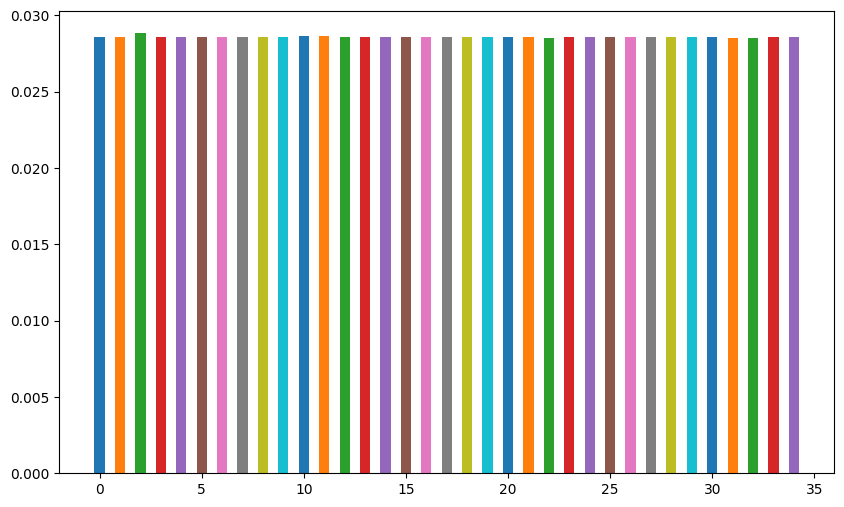

In [46]:
import torch.nn.functional as F
freq = [x/max(counts)/100 for x in counts]
xs=[*range(len(freq))]
ys=F.softmax(torch.tensor(freq).double())

plt.figure(figsize=(10,6), dpi=100)
for x, y in zip(xs, ys):
    plt.bar(x, height=y, width=0.5)
plt.show()

In [53]:
counts

array([ 33,  19, 183,  33,  44,  36,  47,  48,  39,  25,  52,  54,   7,
        16,  19,  33,  17,  13,  16,  13,  25,  12,   5,  22,  29,  16,
        17,  22,   8,   7,  13,   4,   5,   8,  18])

In [48]:
beta = 0.999
effective_num = 1.0 - np.power(beta, counts)
weights = (1.0 - beta) / np.array(effective_num)
weights = weights/np.sum(weights) * len(counts)
weights


array([0.4416831 , 0.76180308, 0.08573839, 0.4416831 , 0.33307844,
       0.40548075, 0.31228287, 0.30592877, 0.37484854, 0.58070434,
       0.2829567 , 0.27274716, 2.05540243, 0.90328849, 0.76180308,
       0.4416831 , 0.8505781 , 1.11007652, 0.90328849, 1.11007652,
       0.58070434, 1.2019827 , 2.87468872, 0.65890558, 0.50160539,
       0.90328849, 0.8505781 , 0.65890558, 1.79937592, 2.05540243,
       1.11007652, 3.59156512, 2.87468872, 1.79937592, 0.80372455])

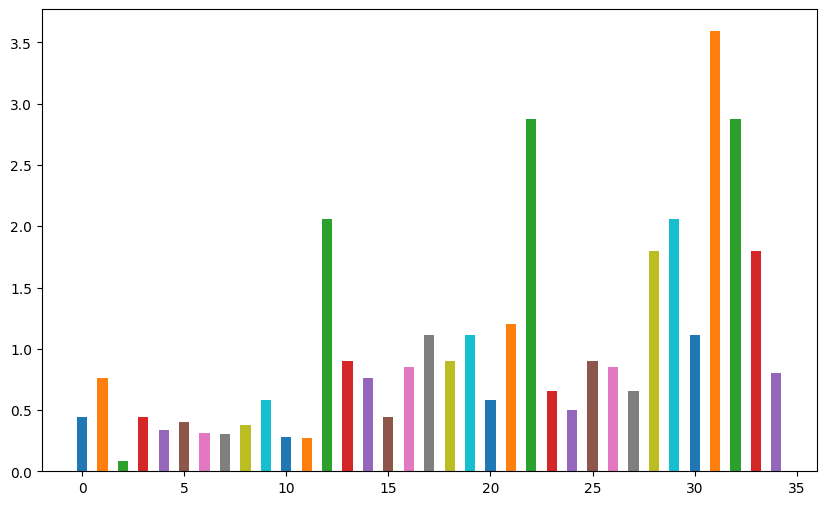

In [49]:
ys = weights
xs = [*range(len(ys))]
plt.figure(figsize=(10,6), dpi=100)
for x, y in zip(xs, ys):
    plt.bar(x, height=y, width=0.5)
plt.show()